# Introduction

LLM fine-tuning almost always requires multiple GPUs to be useful or to be possible at all. But if you're relatively new to deep learning, or you've only trained models on single GPUs before, making the jump to distributed training on multiple GPUs and multiple nodes can be extremely challenging and more than a little frustrating.

We're starting with a very small model [t5-small](https://huggingface.co/t5-small) for a few reasons:
- Learning about model fine-tuning is a lot less frustrating if you start from a place of less complexity and are able to get results quickly!
- When we get to the point of training larger models on distributed systems, we're going to spend a lot of time and energy on *how* to distribute the model, data, etc., across that system. Starting smaller lets us spend some time at the beginning focusing on the training metrics that directly relate to model performance rather than the complexity involved with distributed training. Eventually we will need both, but there's no reason to try to digest all of it all at once!
- Starting small and then scaling up will give us a solid intuition of how, when, and why to use the various tools and techniques for training larger models or for using more compute resources to train models faster.

## Fine-Tuning t5-small
Our goals in this notebook are simple. We want to fine-tune the t5-small model and verify that its behavior has changed as a result of our fine-tuning.

The [t5 (text-to-text transfer transformer) family of models](https://blog.research.google/2020/02/exploring-transfer-learning-with-t5.html) was developed by Google Research. It was presented as an advancement over BERT-style models which could output only a class label or a span of the input. t5 allows the same model, loss, and hyperparameters to be used for *any* nlp task. t5 differs from GPT models because it is an encoder-decoder model, while GPT models are decoder-only models.

t5-small is a 60 million parameter model. This is *small*: the smallest version of GPT2 has more than twice as many parameters (124M); llama2-7b, one of the most commonly-used models at the time of writing, has more than 116 times as many parameters (7B, hence the name). What does this mean for us? Parameter count strongly impacts the amount of memory required to train a model. Eleuther's [Transformer Math blog post](https://blog.eleuther.ai/transformer-math/#training) has a great overview of the memory costs associated with training models of different sizes. We'll get into this in more detail in a later notebook.

## A few things to keep in mind
Check out the [Readme](README.md) if you haven't already, as it provides important context for this whole project. If you're looking for a set of absolute best practices for how to train particular models, this isn't the place to find them (though I will link them when I come across them, and will try to make improvements where I can, as long as they don't come at the cost of extra complexity!). The goal is to develop a high-level understanding and intuition on model training and fine-tuning, so you can fairly quickly get to something that *works* and then iterate to make it work *better*.

## Compute used in this example
I am using a g4dn.4xlarge AWS ec2 instance, which has a single T4 GPU with 16GB VRAM.

# 1. Get the model and try some examples
Before training the model, it helps to have some sense of its base behavior. Let's take a look. See appendix C of the [t5 paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf) for examples of how to format inputs for various tasks.

In [ ]:
%pip install --upgrade transformers torch accelerate
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.3 MB/s eta 0:00:00


2023-12-04 13:13:00.531046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 13:13:00.531105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 13:13:00.531127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 13:13:00.538527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Not uninstalling triton at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Sample text
# input_text = "Translate English to German: The house is wonderful."
input_text = (
    "question: What is the deepspeed license?  context: DeepSpeed "
    "is an open source deep learning optimization library for PyTorch. "
    "The library is designed to reduce computing power and memory use "
    "and to train large distributed models with better parallelism on "
    "existing computer hardware. DeepSpeed is optimized for low latency, "
    "high throughput training. It includes the Zero Redundancy Optimizer "
    "(ZeRO) for training models with 1 trillion or more parameters. "
    "Features include mixed precision training, single-GPU, multi-GPU, "
    "and multi-node training as well as custom model parallelism. The "
    "DeepSpeed source code is licensed under MIT License and available on GitHub."
)

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

2023-12-03 18:33:15.973761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:33:15.973826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:33:15.973849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 18:33:15.981082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


MIT License


# 2. Pick a Fine-Tuning Task

We want to train the model to do something it's not already capable of. Let's see if we can get it to distinguish between a few different programming languages. Is it able to do this now?

In [ ]:
input_text = "question: what programming languauage is this?  code: `df <- read.csv('data.csv'); summary(df)`"

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

df - read.csv('data.csv'


Based on the T5 paper, I couldn't identify a prompt that would elicit this behavior. Furthermore, When T5 was trained, code examples were apparently explicitly excluded. So let's see if we can add this capability.

> Some pages inadvertently contained code. Since the curly bracket “{” appears in many programming languages (such as Javascript, widely used on the web) but not in natural text, we removed any pages that contained a curly bracket.

We will use the [tiny-codes](https://huggingface.co/datasets/nampdn-ai/tiny-codes) dataset, which includes code snippets along with their corresponding language, as training data. Let's pull down the dataset and do a quick exploratory analysis. Then we will have to do some cleaning and prep to make the code usable for our purposes.

# 3. Get and Explore the Data

In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login
# Login
notebook_login()

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:27: UserWarning: This dataset can not be stored in DBFS because either `cache_dir` or the environment variable `HF_DATASETS_CACHE` is set to a non-DBFS path. If this cluster restarts, all saved dataset information will be lost.
  warnings.warn(
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:13: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Rust                         136961
Ruby                         136824
JavaScript                   131014
Julia                        129402
Python                       129063
TypeScript                   128653
Go                           126016
C#                           125478
Java                         123994
Bash                         122804
C++                          120813
Neo4j database and Cypher    117589
relation database and SQL    103698
Name: programming_language, dtype: int64


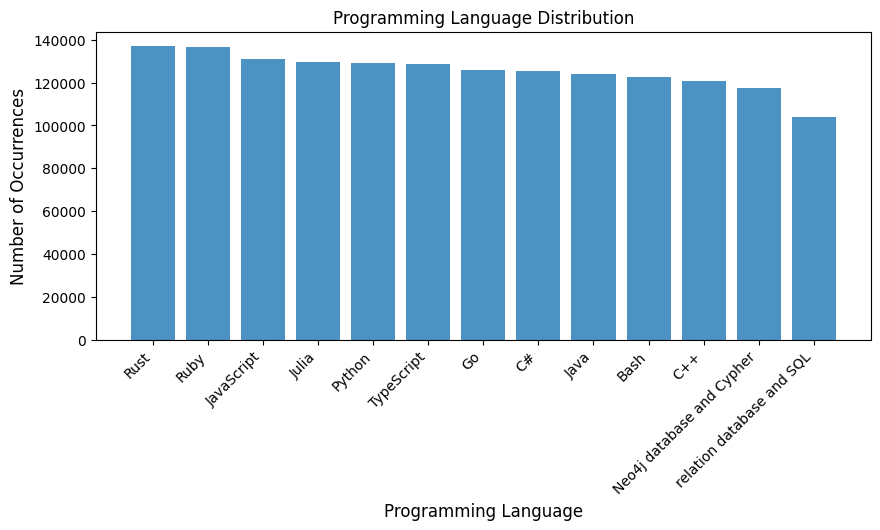

In [ ]:
import matplotlib.pyplot as plt

# Load the dataset
tinycodes = load_dataset('nampdn-ai/tiny-codes')

# Get the counts of the programming_language column
language_counts = tinycodes['train'].to_pandas()['programming_language'].value_counts()

# Print the counts
print(language_counts)

plt.figure(figsize=(10,4))
plt.bar(language_counts.index, language_counts.values, alpha=0.8)
plt.title('Programming Language Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Programming Language', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Angle the x-axis labels to 45 degrees and align them to the right
plt.show()

There are no major imbalances and each of these languages has plenty of examples, so we're not going to do any rebalancing. Now let's take a look at what a given example looks like.

In [ ]:
tinycodes['train'][3]

{'prompt': 'Develop a C# program snippet to Update Low Online Shopping: Product Availability for Analysis for Experts. Incorporate if/else or switch/case statements to handle various cases related to the Privacy. Dry-run, ensure your control flow logic is clear and well-commented.',
 'main_topic': 'Online Shopping',
 'subtopic': 'Product Availability',
 'adjective': 'Low',
 'action_verb': 'Update',
 'scenario': 'for Analysis',
 'target_audience': 'Experts',
 'programming_language': 'C#',
 'common_sense_topic': 'Privacy',
 'idx': 780696,
 'response': 'Here\'s some sample code that demonstrates how to update low online shopping product availability for analysis by experts while incorporating `if`/`else` or `switch`/`case` statements to handle different privacy scenarios:\n```c#\n// Define variables\nstring customerName = "John Doe";\nbool isMinor = false;\nDateTime birthDate = new DateTime(1980, 2, 5);\n\n// Check whether customer is underage based on their date of birth\nif (birthDate >

Given our goal of creating a language classifier, we only need the `programming_language` field and the `response`. We will also need to transform the response, extracting only the code between the backticks (omitting the language name).

In [ ]:
import datasets

def preprocess_tinycodes(tinycodes: datasets.DatasetDict):
    tinycodes_subset = tinycodes["train"].to_pandas()[
        ["idx", "programming_language", "response"]
    ]
    # Extract code from response
    tinycodes_subset["code"] = tinycodes_subset["response"].str.extract(
        r"```[a-zA-Z+#]*\s+([\s\S]*?)```", expand=False
    )
    return tinycodes_subset

In [ ]:
data_test = preprocess_tinycodes(tinycodes)
data_test

,idx,programming_language,response,code
0,1230929,Python,Here is python code which determines high snee...,def determine_high_sneeze_cough_etiquette(isol...
1,1109988,Rust,Here is a possible implementation of such a fu...,// Define a function called display_extreme_se...
2,1881323,Ruby,Here’s some sample ruby code which implements ...,NaN
3,780696,C#,Here's some sample code that demonstrates how ...,"// Define variables\nstring customerName = ""Jo..."
4,131131,Julia,Here is a possible implementation of this func...,NaN
...,...,...,...,...
1632304,1117266,Java,Here is a possible implementation of this requ...,NaN
1632305,1042904,relation database and SQL,Here is a sample relational database schema an...,CREATE TABLE IF NOT EXISTS `user` (\n `id...
1632306,804392,Go,Here is a sample implementation of the functio...,NaN
1632307,1338433,C#,Here is some sample code written in C#:\n\n ...,NaN


You'll notice that this is far from perfect: many examples were not captured by this regex match. Let's investigate.

In [ ]:
import pandas as pd

# Calculate the percentage of NA for each programming language in data_test
na_percent = data_test.groupby("programming_language")["code"].apply(lambda x: x.isna().mean() * 100)

# Display the percentage in a dataframe
na_percent_df = pd.DataFrame(na_percent)
na_percent_df

,code
programming_language,
Bash,18.923651
C#,20.937535
C++,44.289108
Go,42.364462
Java,40.571318
JavaScript,17.117255
Julia,22.030571
Neo4j database and Cypher,53.198854
Python,13.140869


We would generally spend a lot more time iterating on the data and trying to capture code from a much greater proportion of examples. However, in this case, we're just going to subset to those languages where less than 25% of examples are NA and proceed with the fine tuning. Let's update accordingly.

In [ ]:
import numpy as np


def extract_code_from_tinycodes(
    tinycodes: datasets.DatasetDict, train_frac=0.7, valid_frac=0.2
):
    # Subset languages to Bash, C#, JavaScript, Julia, Python, Rust, TypeScript
    languages = ["Bash", "C#", "JavaScript", "Julia", "Python", "Rust", "TypeScript"]
    tinycodes_subset = tinycodes["train"].to_pandas()[
        ["idx", "programming_language", "response"]
    ]
    tinycodes_subset = tinycodes_subset[
        tinycodes_subset["programming_language"].isin(languages)
    ]
    # Extract code from response
    tinycodes_subset["code"] = tinycodes_subset["response"].str.extract(
        r"```[a-zA-Z+#]*\s+([\s\S]*?)```", expand=False
    )
    # Drop rows with missing code
    tinycodes_subset = tinycodes_subset.dropna(subset=["code"])

    # Shuffle the data
    tinycodes_subset = tinycodes_subset.sample(frac=1, random_state=42)
    # Split the data into train, valid, and test sets
    train, valid, test = np.split(
        tinycodes_subset,
        [
            int(train_frac * len(tinycodes_subset)),
            int((train_frac + valid_frac) * len(tinycodes_subset)),
        ],
    )
    # Convert the pandas dataframes back to DatasetDict
    tinycodes_subset = datasets.DatasetDict(
        {
            "train": datasets.Dataset.from_pandas(train),
            "valid": datasets.Dataset.from_pandas(valid),
            "test": datasets.Dataset.from_pandas(test),
        }
    )
    return tinycodes_subset

In [ ]:
tinycodes_subset = extract_code_from_tinycodes(tinycodes)
tinycodes_subset

DatasetDict({
    train: Dataset({
        features: ['idx', 'programming_language', 'response', 'code', '__index_level_0__'],
        num_rows: 542106
    })
    valid: Dataset({
        features: ['idx', 'programming_language', 'response', 'code', '__index_level_0__'],
        num_rows: 154888
    })
    test: Dataset({
        features: ['idx', 'programming_language', 'response', 'code', '__index_level_0__'],
        num_rows: 77444
    })
})

In [ ]:
# count number of each programming language
tinycodes_subset['train'].to_pandas()['programming_language'].value_counts()


Rust          91672
TypeScript    86330
Python        78563
JavaScript    75690
Julia         70475
Bash          69789
C#            69587
Name: programming_language, dtype: int64

We still have a reasonably balanced training set, with between 69,000 and 92,000 examples of each language. Let's proceed! Next we need to preprocess the data for training by adding a prefix specifying the task and then tokenizing the data.

## Tokenize the Dataset

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")


def preprocess_function(examples, tokenizer):
    prefix = "question: what programming language is this?  code:\n\n"
    inputs = [prefix + ex for ex in examples["code"]]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding="max_length"
    )

    labels = tokenizer(
        text_target=examples["programming_language"],
        max_length=128,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Assuming 'dataset' is your DatasetDict
tokenized_datasets = tinycodes_subset.map(
    preprocess_function,
    fn_kwargs={"tokenizer": tokenizer},
    batched=True,
    batch_size=4096,
    load_from_cache_file=True,
)

2023-12-03 18:48:53.085806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:48:53.085867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:48:53.085905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 18:48:53.092029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Map:   0%|          | 0/542106 [00:00<?, ? examples/s]

Map:   0%|          | 0/154888 [00:00<?, ? examples/s]

Map:   0%|          | 0/77444 [00:00<?, ? examples/s]

In [ ]:
# set up dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=16)
val_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=16)


# Start Training

In [ ]:
import torch
import mlflow
from transformers import Trainer, TrainingArguments, AutoModelForSeq2SeqLM

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = "t5-small"  # Or another T5 variant
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="/Volumes/daniel_liden/fine_tune/assets/results/",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=1e4,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    logging_dir="/Volumes/daniel_liden/fine_tune/assets/logs/",
    learning_rate=2e-5,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)


# Start training
with mlflow.start_run():
    trainer.train()


Using device: cuda


Step,Training Loss,Validation Loss
10000,0.000500,0.000561
20000,0.000400,0.000407
30000,0.000300,0.000386
40000,0.000400,0.000346
50000,0.000400,0.000346


In [ ]:
import gc

del model
del tokenizer
del trainer
torch.cuda.empty_cache()
gc.collect()

7274

# Inference with our fine-tuned model

Before we get too far, there are a few important things to point out here:
- The choice of training hyperparameters was more-or-less arbitrary. In real life, we would do a lot more experimentation with e.g. batch size, regularization, etc.
- Similarily, the data mix was chosen for expediency, not for suitability for the current task. If I had to venture a guess before seeing any results, I would guess that the model learned shortcuts 

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("/Volumes/daniel_liden/fine_tune/assets/results/checkpoint-50823")

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

input_texts = [
    "question: what programming language is this?  code: def add_a_b(a, b): return a + b",  # Python
    "question: what programming language is this?  code: public class HelloWorld { public static void Main() { Console.WriteLine(\"Hello, World!\"); } }",  # C#
    "question: what programming language is this?  code: #include <iostream> int main() { std::cout << \"Hello, World!\" << std::endl; return 0; }",  # C++
    "question: what programming language is this?  code: println(\"Hello, World!\")",  # Julia
    "question: what programming language is this?  code: echo \"Hello, World!\"",  # Bash
    "question: what programming language is this?  code: fn main() { println!(\"Hello, World!\"); }"  # Rust
]

# Tokenize and encode the batch of input texts
input_ids = tokenizer.batch_encode_plus(input_texts, padding=True, return_tensors="pt", truncation=True).to(device)

# Generate responses for the batch
output_ids = model.generate(input_ids["input_ids"], max_new_tokens=20)

# Decode and print the output texts
for i, output_id in enumerate(output_ids):
    output_text = tokenizer.decode(output_id, skip_special_tokens=True)
    print(f"Input: {input_texts[i]}")
    print(f"Output: {output_text}\n")


Input: question: what programming language is this?  code: def add_a_b(a, b): return a + b
Output: Python

Input: question: what programming language is this?  code: public class HelloWorld { public static void Main() { Console.WriteLine("Hello, World!"); } }
Output: C#

Input: question: what programming language is this?  code: #include <iostream> int main() { std::cout << "Hello, World!" << std::endl; return 0; }
Output: Rust

Input: question: what programming language is this?  code: println("Hello, World!")
Output: Julia

Input: question: what programming language is this?  code: echo "Hello, World!"
Output: Bash

Input: question: what programming language is this?  code: fn main() { println!("Hello, World!"); }
Output: Rust



It misclassified C++ code as Rust code, but otherwise got the examples correct. We've added a new capability to this model. Now the question is...does it still remember how to do what it was trained on before?

In [ ]:
input_text = (
    "question: What is the deepspeed license?  context: DeepSpeed "
    "is an open source deep learning optimization library for PyTorch. "
    "The library is designed to reduce computing power and memory use "
    "and to train large distributed models with better parallelism on "
    "existing computer hardware. DeepSpeed is optimized for low latency, "
    "high throughput training. It includes the Zero Redundancy Optimizer "
    "(ZeRO) for training models with 1 trillion or more parameters. "
    "Features include mixed precision training, single-GPU, multi-GPU, "
    "and multi-node training as well as custom model parallelism. The "
    "DeepSpeed source code is licensed under MIT License and available on GitHub."
)

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

C#


There's an interesting result here: if we try the input above after training for all three epochs, we get an incorrect result. However, if we use the checkpoint saved after only two epochs, it still gets the correct answer. This highlights something really important: fine-tuning on new knowledge or new tasks can make the model "forget" its prior training. To get around this, we need to be thoughtful about how much new data we use, how long we train for, how we evaluate the fine-tuned model, and what mixture of data we use for fine-tuning.

# Conclusion

In this example, we fine-tuned `t5-small` on a new task. The basic process was:
- Pick a model and task
- Pick a dataset
- Process the dataset
- Train the model on the processed dataset

This omits plenty of important steps we'll get further into in future notebooks. For example:
- tuning hyperparameters
- thoroughly evaluating the results
- tuning training speed/efficiency
- monitoring the training loop (we did track the experiment with MLflow but did not configure it in any way for our specific usage)

We will get into each of these in future examples.